## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these. 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
%matplotlib inline

# Setting the 'seed' to assure it conforms to Udacity's random number generator specification

random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`. 

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
# Number of rows 

df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
# Number of unique users 

df.groupby('user_id')['user_id'].nunique().sum()

290584

d. The proportion of users converted.

In [5]:
# Proportion of users converted is indicated by frequency of "1"

df['converted'].value_counts(normalize=True)*100

0    88.034081
1    11.965919
Name: converted, dtype: float64

The answer for the proportion of users converted is **11.96**.

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
# df.query('B > 50 and C != 900')

df.query("(group == 'treatment' and landing_page != 'new_page') or (group != 'treatment' and landing_page == 'new_page')")['user_id'].count()


3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

We have **no** missing values.

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
columns_drop = df.query("(group == 'treatment' and landing_page != 'new_page') or (group != 'treatment' and landing_page == 'new_page') or (group == 'control' and landing_page != 'old_page') or (group != 'control' and landing_page == 'old_page')")
df2 = df.drop((columns_drop).index)

In [9]:
# Double Check all of the correct rows were removed - this should be 0

df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
# Detecting the duplicate user_id

repeat = df2.duplicated(['user_id'], keep=False)
df2[repeat]['user_id']

1899    773192
2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
df2.query("user_id == 773192") # Filtering those rows for duplicate user_id

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
# Remove ealier timestamp i.e. keep the latest one

remove_duplicate = df.query("(user_id == 773192) and (timestamp == '2017-01-09 05:37:58.781806')")
df2.drop((remove_duplicate).index, inplace=True)
df2.query("user_id == 773192")

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


$$P(converted|control) = P(converted & control)/P(control)$$

In [16]:
converted_control = df2.query("converted == 1 and group == 'control'")['user_id'].count()
control = df2.query("group == 'control'")['user_id'].count()
ccp = converted_control/control
ccp

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

$$P(converted|treatment) = P(converted & treatment)/P(treatment)$$

In [17]:
converted_treatment = df2.query("converted == 1 and group == 'treatment'")['user_id'].count()
treatment =  df2.query("group == 'treatment'")['user_id'].count()
cct = converted_treatment/treatment
cct

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
user_new_page = df2.query("landing_page == 'new_page'")['user_id'].count()
user_prob = user_new_page/df2.shape[0]
user_prob

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

* The probability of an individual ```coverting``` (irrespective of the page they received) is 11.96%.
* Given that an individual was in the ```control group```, the probability they ```converted``` is 12.04.
* Given that an individual was in the ```treatment group```, the probability the user ```converted``` is 11.88%.
* The evidence in comparing the probabilities of user conversions among ```control``` and ```treatment``` group are almost identical, alongside the probability of an individual ```converting``` regardless of the page they received.
* Hence, there is ***insufficient evidence*** to suggest that the new page leads to greater ```conversions```.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

***
$$H_{0} : p_{new} - p_{old} ≤ 0$$

$$H_{1} : p_{new} - p_{old} > 0$$
***

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

In [19]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


a. What is the **conversion rate** for $p_{new}$ under the null? 

In [20]:
# Could be done in Same way as in part 1 - probababily question 4a.
# df2['converted'].value_counts(normalize=True)*100

p_new = df2['converted'].mean()

p_new # Print coversion rate for p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [21]:
# Given p_new and p_old are equal, p_old conversion rate is also the same

p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [22]:
# Computing the number of individuals in the treatment group

n_new = df2.query("group == 'treatment'").shape[0]

n_new # Print n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [23]:
# Computing the number of individuals in the control group 

n_old = df2.query("group == 'control'").shape[0]

n_old # Print n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
# Simulate n_new under the corresponding conversion rate of p_new

binary = [0,1]
new_page_converted = np.random.choice(binary, n_new, p=[p_new, (1-p_new)])


new_page_converted # Print new_page_converted

array([1, 1, 1, ..., 1, 1, 1])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
# Simulate n_old under the corresponding conversion rate of p_old

binary = [0,1]
old_page_converted = np.random.choice(binary, n_old, p=[p_old, (1-p_old)])

old_page_converted # Print old_page_converted

array([1, 0, 1, ..., 1, 1, 1])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
# Difference in probabilities for new and old groups in the above criteria e) - f).

new_page_converted.mean() - old_page_converted.mean()

-0.0005830199452708795

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [27]:
p_diffs = []
size = df2.shape[0]
binary = [0,1]

# This took around 10-15 minutes to complete - inefficient
'''
for i in range(10000):
    b_samp = df2.sample(size, replace = True) # We want to sample with replacement for boostrap sample
    new_page_converted = np.random.choice(binary, n_new, p=[p_new, (1-p_new)])
    old_page_converted = np.random.choice(binary, n_old, p=[p_old, (1-p_old)])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean()) 
''' 

'\nfor i in range(10000):\n    b_samp = df2.sample(size, replace = True) # We want to sample with replacement for boostrap sample\n    new_page_converted = np.random.choice(binary, n_new, p=[p_new, (1-p_new)])\n    old_page_converted = np.random.choice(binary, n_old, p=[p_old, (1-p_old)])\n    p_diffs.append(new_page_converted.mean() - old_page_converted.mean()) \n'

In [28]:
# Faster version of simulation using built-in instead of for loop - thanks to my udacity reviewer/mentor for the tip

new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [29]:
p_diffs = np.array(p_diffs)

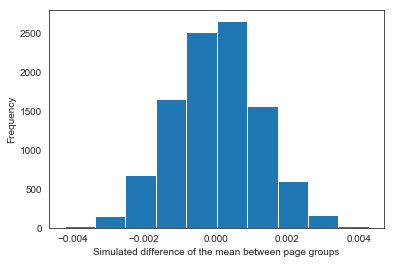

In [30]:
plt.hist(p_diffs);
_ = plt.xlabel('Simulated difference of the mean between page groups') # The '_' removes arbitary text regarding plot dimensions
_ = plt.ylabel('Frequency')

* This plot that illustrates the sampling distribution of p_diffs depicts a normal distribution, where the mean difference of treatment and controls groups lies around 0. 
* The observed phenomena is expected, as it reflects the central limit theorem, where large samples among a sampling distributions correspond to a mean value that is close to the population (normal) mean.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [31]:
# Compute the observed differences - conversions both groups computed as above in part 1: question 4) b and c.

control_conversion = df2.query("group == 'control' & converted == 1")['user_id']
treatment_conversion = df2.query("group == 'treatment' & converted == 1")['user_id']

obs_diffs = treatment_conversion.count()/n_new - control_conversion.count()/n_old

# Display the observed difference in the data

obs_diffs

-0.0015782389853555567

In [32]:
# Could've also used:

control_conversion = df2.query('group == "control"')['converted'].mean()
treatment_conversion = df2.query('group == "treatment"')['converted'].mean()

obs_diffs = treatment_conversion - control_conversion
obs_diffs

-0.0015782389853555567

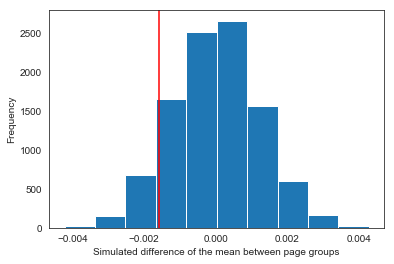

In [33]:
# Plot the point of observed differences on the bootstrap samples: p_diffs

_ = plt.hist(p_diffs)
_ = plt.axvline(x= obs_diffs, color='r')
_ = plt.xlabel('Simulated difference of the mean between page groups')
_ = plt.ylabel('Frequency')

In [34]:
# Computing the proportion (p_val) of p_diffs > obs_diffs

p_val = (p_diffs > obs_diffs).mean()
print(('{0:0.3f}').format(p_val))

0.902


k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

* The above histogram plots the sampling distributon under the null hypothesis of this A/B test - where the red line also illustrates where the mean of the observed differences lie.
* The above computation is seen as the p-value where given the null hypothesis - the difference in new and old page attributes are the same - the conversion rate of the control group is equal to the conversion rate of the treatment group. 
* The p-value specfically displays the probability (expected value) of the bootstramp sample (p_diffs) being greater than the expected value of the dataset differences (observed differences).
* A p-value of 0.906 is significantly greater than the Type I error rate of 5%, meaning we fail to reject the null hypothesis of new page returns being less than or equal to returns to the old page.
* Hence, the e-commerce website should refrain from using new page features and remain with its old page layout.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [35]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [36]:
import statsmodels.api as sm

convert_old = df2.query("group == 'control' & converted == 1")['user_id'].count()
convert_new = df2.query("group == 'treatment' & converted == 1")['user_id'].count()
n_old = df2.query("group == 'control'").shape[0]
n_new = df2.query("group == 'treatment'").shape[0]

In [37]:
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [38]:
# We want to find if new pages are better than the old, hence given its a one-sided test, pick 'larger'
# Bare in mind that the zstat value is taken as absolute

zstat, p_value = sm.stats.proportions_ztest(np.array([convert_new,convert_old]),np.array([n_new,n_old]), alternative = 'larger')

In [39]:
from scipy.stats import norm
''' we want to find the critical region for which a z-score/zstat verifies whether to reject or accept the null hypothesis'''

crit_val_ci = norm.ppf(0.975) # 5% error rate (95% confidence interval - ci) i.e. 2.5% on each side
crit_val_one = norm.ppf(0.95) # 5% error rate one-sided
print('{0:0.3f}'.format(crit_val_ci))
print('{0:0.3f}'.format(crit_val_one))

1.960
1.645


In [40]:
# Display the z statistic and p-value respectively - rounded to 3dp

print('{0:0.3f}'.format(zstat)) # test statistic 
print('{0:0.3f}'.format(p_value)) 

-1.311
0.905


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

* As the z statistic (1.31) falls below the range of the critical value of at the 5% error rate (1.96) and 2.5% error rate (1.645), we fail to reject the null hypothesis. 
* The null hypothesis is that there is no statistical difference between the conversion rates for the control and treatment groups.

* Additionally, since the p_value of 0.905 (around the same value as calculated via bootstrap simulation using the p-value of p_diff > obs_diff) is larger than the alpha value (Type I error rate) of 0.05, we fail to reject the null hypothesis.

* Thus, as suggested by the p-value calculcated from the sampling distributon above, the built-in ```(stats.proportions_ztest)``` method leads to an identical conclusion justified above, where the e-commerce website should stick with the old page rather than implementing new page features.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression**:
<br>
We are trying to fit a model that compares binary categorical groups - which requires logistic regression when attempting to capture the dependent and independent variable association.

In [41]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [42]:
# Add the intercept 

df2['intercept'] = 1

In [43]:
# Adding ab_page column

df2[['added', 'ab_page']] = pd.get_dummies(df2['group'])
df2 = df2.drop('added', axis='columns') # Drop the 'added column'
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [44]:
# Dependent variable: converted ; independent variables: intercept, ab_page

logit_model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [45]:
# Model fit

results = logit_model.fit()
results.summary() # Display the summary 

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 09 Aug 2019   Pseudo R-squ.:               8.077e-06
Time:                        21:06:59   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

* The p-value associated with ab_page is 0.190, compared with a p-value ≈0.905 found in **Part II** using the bootstrap simulation and z-statistic built-in.
* The logistical regression model attempts to illustrate if there is any relationship between users conversions and the ab_page layout (page a user received), enabling us to estimate a relationship among the variables and make predictions.
* The ```null hypothesis``` of the regression model is that there is no *significant* relationship between the number of conversions and the page a user received. Conversely, the ```alternative hypothesis``` of the regression model is that there is a *significant* relationship between the number of conversions and the page a user received, given the separation of pages received between treatment (receiving new pages) and control (remained with the old page) groups.
* Given the A/B test in **Part II**, the ```null hypothesis``` stated that the new page performed the *same or worse* than the old page layout in terms of conversions, while the ```alternative hypothesis``` stated the new page performed *better* than the old page layout in terms of conversions.
* The differences in p-values then is that in **Part II** we attempted to find the difference where the proportion of users converted greater than the observed difference of conversions as our test statistic, while the p-value found in logistical regression notes within the model that there is a relationship between conversions and pages received, given us evidence to make a prediction in terms of the stated effect.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

* Including more explanatory variables (predictors/factors) possibly helps explain the relationship in this case whether an individuals converts or not. 
* We can reduce omitted variable bias, where another related factor not previously included such as the time, given the year, month or season *can* affect the association (**seasonality**) between conversions after new page features are implemented, better explaining the predicted relationship and possibly causing the $R^2$ (the proportion of the variance displayed by the dependent variable that is predictable from the independent variables) to increase given its inclusion, possibly increasing predictive justifications when added factors support goodness of fit criteria.
* Conversely, the disadvantages to adding additional terms/transformations could lead to an overfitting of the data, where adding more closely related factors could cause overestimation within the predicted values being observed. Moreover, adding factors can needlessly complexify the model, while possibly misunderstanding causality (little evidence to suggest that changes in one such quantities causes changes in the other) with correlation, which increase the likelihood of making unsound statistical conclusions including false positives.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [46]:
# Reading in the countries.csv 

countries_df = pd.read_csv('countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [47]:
# Joining the countries_df and df2 using merge - utilising left join (i.e. matching all entries from ab dataset)

df3 = df2.merge(countries_df, how='left', on='user_id')
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [48]:
counts = df3.country.value_counts()
counts # Three countries of interest: US, UK and Canada
# Columns: keep only two countries (US and UK) and drop 1 (Canada) for our dummy variable requirements

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [49]:
df3[['CA', 'UK', 'US']] = pd.get_dummies(df3['country'])
df3 = df3.drop('CA', axis='columns')

In [50]:
df3.head() # Check 

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,1


In [51]:
# Logit model country fitting

logit_mod_country = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'US', 'UK']])
res = logit_mod_country.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 09 Aug 2019   Pseudo R-squ.:               2.323e-05
Time:                        21:07:00   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

In [52]:
1/np.exp(-0.0150)

1.015113064615719

In [53]:
# Need to exponentiate the coefficienct values for interpretation under logistical regression

print('The exponential coefficienct for ab_page is:', round(1/np.exp(-0.0149), 2)) # use a reciprocal for -ve values
print('The exponential coefficient for US is:', round(np.exp(0.0408), 2)) # round to 2 dp
print('The exponential coefficient for UK is:', round(np.exp(0.0506), 2))

The exponential coefficienct for ab_page is: 1.02
The exponential coefficient for US is: 1.04
The exponential coefficient for UK is: 1.05


* Our baseline/reference is Canada (the country dropped).
* For every 1 unit decrease in A/B page landings between the groups (whether on not it was a new or old page landing), conversion is 1.02 times likely to occur holding all else constant.
* For every 1 unit increase in US page landings, conversion is 1.04 times likely to occur compared to Canadian users holding all other variables constant.
* For every 1 unit increase in UK page landings, conversion is 1.05 times likely to occur compared to Canadian users holding all other variables constant.
<br>
<br>
Moreover, the p-values of these respective coefficients are larger than our 5% Type I error rate, confirming that we fail to reject the null hypothesis of the implementation regarding new page layout being the same/worse than the old page, as there is a lack of statistical and practical significance thus far.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [54]:
# Setting up the interaction terms between ab_page and each country (US and UK)

df3['US_page'] = df3['ab_page'] * df3['US']
df3['UK_page'] = df3['ab_page'] * df3['UK']

In [55]:
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US,US_page,UK_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,1,0,0


In [56]:
# Fitting the model between country and page interactions

logit_mod_page_country = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'UK','UK_page','US','US_page']])
res = logit_mod_page_country.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 09 Aug 2019   Pseudo R-squ.:               3.482e-05
Time:                        21:07:00   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
UK_page        0.0783      0.057      1.378      0.168      -0.033       0.190
US             0.0175      0.038      0.465      0.642      -0.056       0.091
US_page        0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

In [57]:
print('The exponential coefficient for ab_page is:', round(1/np.exp(-0.0674), 2))
print('The exponential coefficient for UK is:', round(np.exp(0.0118), 2))
print('The exponential coefficient for UK_page is:', round(np.exp(0.0783), 2))
print('The exponential coefficient for US is:', round(np.exp(0.0175), 2))
print('The exponential coefficient for US_page is:', round(np.exp(0.0469), 2))

The exponential coefficient for ab_page is: 1.07
The exponential coefficient for UK is: 1.01
The exponential coefficient for UK_page is: 1.08
The exponential coefficient for US is: 1.02
The exponential coefficient for US_page is: 1.05


* The interaction terms (UK_page and US_page) illustrate a higher coefficienct value than their country variables alone. Yet it does not offer added/unique insights then country measures alone.
* Altogether, the p-values remain larger than the 5% Type I error rate, justifying that we should fail to reject the null hypothesis given a lack of statistical significance. The z-values for each coefficient are also below the z-statistic (z-score) for a 95% confidence interval (1.96).
* This reiterates that adding a country variable has no observed effect on conversion rates for the e-commerce website in terms of page landings.
* For every 1 unit decrease in A/B page landings between the groups (whether on not it was a new or old page landing), conversion is 1.07 times likely to occur holding all else constant.
* For every 1 unit increase in UK page landings, conversion is 1.01 times likely to occur compared to Canadian users holding all other variables constant.
* For every 1 unit increase in UK page landings * ab page, conversion is 1.08 times likely to occur compared to Canadian users holding all other variables constant.
* For every 1 unit increase in US page landings, conversion is 1.02 times likely to occur compared to Canadian users holding all other variables constant.
* For every 1 unit increase in US page landings * ab page, conversion is 1.05 times likely to occur compared to Canadian users holding all other variables constant.